In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from iminuit import Minuit
from scipy.interpolate import interp1d
import glob
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pickle
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di
%matplotlib notebook

In [2]:
%matplotlib notebook

def trafo(Input):
    weights = []
    weights.append(1) #at R=0 we assume CE = 1
    for im in Input:
        if np.isnan(im):
            print("blah1")
            im=0
        vl = weights[-1]-im
        vl = vl if vl>0 else 0 
        if np.isnan(vl):
            print("blah")
        weights.append(vl)
        
    return np.array(weights)

def inverse_trafo(weights):
    # The input should be a numpy array, starting with 1
    if len(weights) == 0:
        return []
    input_vals = [] # Start with an empty list
    for i in range(1, len(weights)):
        diff = weights[i-1] - weights[i]
        input_vals.append(diff)
    return np.array(input_vals)


def model_old(weights):

    weights = trafo(weights) #fit parameters is difference to last weight, but we need the weights

    line = []
    f = interp1d(np.append(0,x+step/2.), weights, kind = "slinear") 
    weights_detailed = f(Rbins_x)

    for r in Rs:
        line.append(np.nansum(dicts[r]["hist"]*weights_detailed/dicts[r]["counts"])*100/N)#/np.sum(dicts[r]))
        
    line = np.array(line)
    mn = []
    bl2 = Rs<Rhist[0]
    mn.append(np.nanmean(line[line>0][bl2[line>0]]))
    for i in range(Rhist.size-1):

        bl2 = np.logical_and(Rs<Rhist[i+1], Rs>=Rhist[i] )
        mn.append(np.nanmean(line[bl2]))

    line = np.array(mn)
    norm = np.nanmean(line[line>0][Rhist[line>0]<Rcentre])
    
    return np.array(line)/norm  
 

def model(weights):
    weights = trafo(weights) #fit parameters is difference to last weight, but we need the weights

    #f = lambda xi: np.interp(xi, np.append(0, x + step / 2.), weights) #
    f = interp1d(np.append(0, x + step / 2.), weights, kind = "slinear") 
    weights_detailed = f(Rbins_x)

    line = np.array([np.nansum(dicts[r]["hist"] * weights_detailed / dicts[r]["counts"]) * 100 / N for r in Rs])


    # Preallocate mn array
    mn = np.empty(Rhist.size)
    mask = np.logical_and(line > 0, Rs < Rhist[0])
    mn[0] = np.nanmean(line[mask])
    for i in range(1, Rhist.size):
        mn[i] = np.nanmean(line[bl2_masks[i-1]])

    norm = np.nanmean(mn[mn>0][Rhist[mn>0]<Rcentre])

    return mn / norm



def chi(*args):
    mdl = model(args)

    return np.nansum((y[mdl>0] - mdl[mdl>0]) ** 2 / y_err[mdl>0] ** 2)

# DOM

In [3]:
%%capture
step = .5
Rbins = np.arange(0,130+step,step)
Rbins_x = 0.5*(Rbins[:-1]+Rbins[1:])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def readfn(fname):
    xd, yd = np.loadtxt(fname, unpack=1, usecols=(0,1), skiprows=1)
    xd *= 1000
    yd *= 1000
    R = np.sqrt(xd**2+yd**2)

    h, bins = np.histogram(R, bins = Rbins)   
    return h

xx = np.arange(-129, 130, 1)
matrix = np.zeros((xx.size,xx.size))#+np.nan

dicts = {}
Rs = np.arange(0, 130, 1)

for r in Rs:
    dicts[r] = {} 
    dicts[r]["hist"] = np.zeros(Rbins.size-1)
    dicts[r]["counts"] = 0

# for i,x in enumerate(xx):
#     for j,y in enumerate(xx):
#         Rfile = np.sqrt(x**2+y**2)
#         try:
#             #fname = f"SimulationScan/output{thickness}/{x}_{y}.txt"
#             fname = f"DOMScan/{x}_{y}.txt"
#             h = readfn(fname)
#             dicts[find_nearest(Rs,Rfile)]["hist"] += h
#             dicts[find_nearest(Rs,Rfile)]["counts"] +=1
#         except Exception as err:
#             print(err)
#             pass
# with open(f'saved_dictionary_detailed_DOM.pkl', 'wb') as f:
#     pickle.dump(dicts, f)

<IPython.core.display.Javascript object>


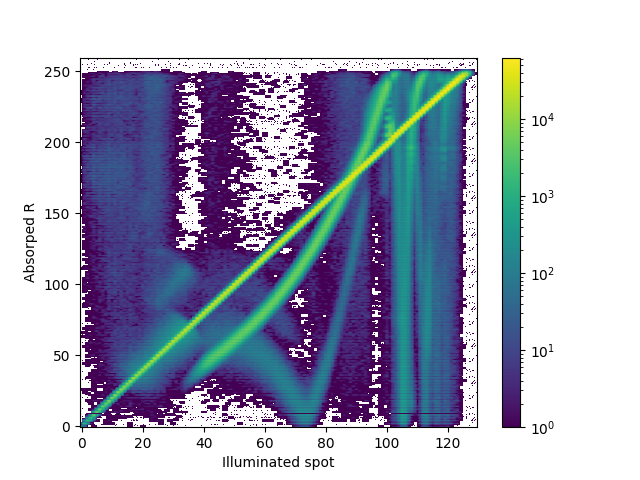

Text(0, 0.5, 'Absorped R')

In [4]:
dicts = load_dict(f"saved_dictionary_detailed_DOM.pkl")
N= 1000
matrix = []
mean = []
maxp = []
for r in Rs:
    matrix.append(dicts[r]["hist"])#/np.sum(dicts[r]))
    try:
        mean.append(np.average(Rbins_x, weights=dicts[r]["hist"]))
        maxp.append(np.mean(Rbins_x[dicts[r]["hist"]==np.amax(dicts[r]["hist"])]))
    except:
        mean.append(0)
        maxp.append(0)
maxp = np.array(maxp)
plt.figure()
im = plt.imshow(np.array(matrix).T, aspect="auto", origin="lower", norm = LogNorm())
plt.colorbar(im)
plt.xlabel("Illuminated spot")
plt.ylabel("Absorped R")


dict_keys(['x', 'y', 'rDE', 'gain', 'TT', 'TTS', 'size', 'R', 'ix', 'iy', 'occupancy', 'TTS_c'])


<IPython.core.display.Javascript object>


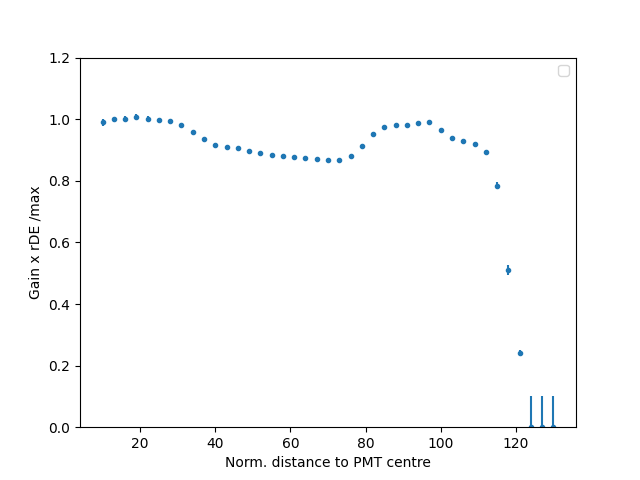

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


102.15223015186697 131


In [5]:
path = "/HDD/backuped/Promotion_data/Thesis/"
DOM = load_dict(path+"data/data_in_elements/DOM_dictionary")
x0 = -3
y0 = -1
DOM["R"] = np.sqrt((DOM["x"]-x0)**2+(DOM["y"]-y0)**2)
print(DOM.keys())

rmax = 131#253/2

rnorm = 253/2
Rcentre = 40
step = 3
#Rhist = np.arange(step*3,1,step*2)
Rhist = np.arange(10,rmax,step)

key = "rDE"

lim = 0.2
plt.figure()

dictionary = DOM
print(0.75*np.amax(dictionary["R"]), rmax)
meanSize = np.mean(dictionary["size"][dictionary["R"]<lim*np.amax(dictionary["R"])])

bl = np.logical_and(dictionary["size"]>meanSize*0.05, dictionary["R"]<rmax)
norm = np.mean(dictionary[key][dictionary["R"]<lim*np.amax(dictionary["R"])])*np.mean(dictionary["rDE"][dictionary["R"]<lim*np.amax(dictionary["R"])])

#plt.plot(dictionary["R"][bl]/rmax, dictionary[key][bl]/norm, '.', alpha = 0.5, markersize = 1)
mn = []
std = []
for R in Rhist:
    bl2 = np.logical_and(dictionary["R"][bl] > R-step, dictionary["R"][bl]<R+step)
    if (dictionary[key][bl])[bl2].size > 1:
        if R>122:
            mn.append(0)
            std.append(0)
        else:
            mn.append(np.mean((dictionary[key][bl])[bl2]))
            std.append(np.std((dictionary[key][bl])[bl2])/np.sqrt((dictionary[key][bl])[bl2].size-1))
    else:
        mn.append(0)
        std.append(0)
    
        
mn = np.array(mn)
norm = np.mean(mn[Rhist<25])
y = mn/norm
y_err = np.array(std)/norm
for i in range(y_err.size):
    if y_err[i] == 0:
        y_err[i] = 0.1
x=Rhist.copy()
plt.errorbar(Rhist, y, yerr=y_err, fmt= '.')
    
plt.legend()
plt.ylabel("Gain x rDE /max")
plt.xlabel("Norm. distance to PMT centre")
plt.ylim(0,1.2)



# Pre-calculate bl2 masks to avoid repeated computation
bl2_masks = np.empty((Rhist.size-1, Rs.size), dtype=bool)
for i in range(Rhist.size-1):
    bl2_masks[i] = np.logical_and(Rs < Rhist[i+1], Rs >= Rhist[i])


In [34]:
%%timeit -n 1000
model(np.random.rand(x.size))

3.8 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
# oldx, oldy = np.loadtxt("weightsVsR_vFit_220nm.txt", unpack=1)
diffs = [0,]
for i in range(Rhist.size-1):
    diffs.append(0.0001)
    
f = interp1d(Rhist, diffs)
in_values = f(Rhist)
print(in_values)
initial = {}
limits = {}
fix = {}
error = {}
names = list()
for i,val in enumerate(m.np_values()):
    names.append("w_"+str(i))
    initial[names[-1]] = val
    if i<5:
        limits["limit_"+names[-1]] = (0.0, 0.01)
#     elif i<20:
#         limits["limit_"+names[-1]] = (0.0, 0.05)
    elif i>34:
        limits["limit_"+names[-1]] = (0.0, 0.5)
    else:
        limits["limit_"+names[-1]] = (-0.1, 0.1)
        
    error["error_"+names[-1]] = 0.5
    fix["fix_"+names[-1]] = False
 
#print(model(np.ones(Rhist.size)))

minuit_args = {**initial, **limits, **error, **fix, **dict(errordef= 1)}


m = Minuit(chi, name=names, **minuit_args)
m.strategy = 0
m.tol = 1e-12
m.migrad(ncall = 500000)



[0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001]


------------------------------------------------------------------
| FCN = 969.2                   |    Ncalls=672 (18250 total)    |
| EDM = 1.16e-09 (Goal: 2e-15)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | w_0  |  10.0e-3  |  0.4e-3   |            |            |    0    |  0.01   |       |
| 1 | w_1  | 10.00e-3  |  0.33e-3  |            |            |    0    |  0.01   |       |
| 2 | w_2  | 10.00e-3  |  0.28e-3  |            |            |    0    |  0.01   |       |
| 3 | w_3  | 10.00e-3  |  0.27e-3  |            |            |    0    |  0.01   |       |
| 4 | w_4  |  10.0e-3  |  0.4e-3   |            |            |    0    |  0.01   |       |
| 5 | w_5  |  0.1000   |  0.0026   |            |            |  -0.1   |   0.1   |       |
| 6 | w_6  | -46.1e-3  |  0.6e-3   |            |            |  -0.1   |   0.1   |       |
| 7 | w_7  |  45.4e-3  |  0.5e-3   |            |            |  -0.1   |   0.1   |       |
| 8 | w_8  | -46.4e-3  |  0.5e-3   |            |            |  -0.1   |   0.1   |       |
| 9 | w_9  | 100.00e-3 |  0.23e-3  |            |            |  -0.1   |   0.1   |       |
| 10| w_10 | 100.00e-3 |  0.09e-3  |            |            |  -0.1   |   0.1   |       |
| 11| w_11 | 100.00e-3 |  0.16e-3  |            |            |  -0.1   |   0.1   |       |
| 12| w_12 |  21.2e-3  |  0.6e-3   |            |            |  -0.1   |   0.1   |       |
| 13| w_13 |  2.4e-3   |  0.6e-3   |            |            |  -0.1   |   0.1   |       |
| 14| w_14 |  9.6e-3   |  0.6e-3   |            |            |  -0.1   |   0.1   |       |
| 15| w_15 |  -1.8e-3  |  0.7e-3   |            |            |  -0.1   |   0.1   |       |
| 16| w_16 | -39.9e-3  |  0.7e-3   |            |            |  -0.1   |   0.1   |       |
| 17| w_17 | -41.6e-3  |  0.8e-3   |            |            |  -0.1   |   0.1   |       |
| 18| w_18 |  -9.0e-3  |  0.8e-3   |            |            |  -0.1   |   0.1   |       |
| 19| w_19 |  -3.2e-3  |  0.8e-3   |            |            |  -0.1   |   0.1   |       |
| 20| w_20 |  -0.7e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 21| w_21 |  11.8e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 22| w_22 | -33.9e-3  |  1.0e-3   |            |            |  -0.1   |   0.1   |       |
| 23| w_23 |  -0.0487  |  0.0011   |            |            |  -0.1   |   0.1   |       |
| 24| w_24 |  -0.0172  |  0.0011   |            |            |  -0.1   |   0.1   |       |
| 25| w_25 |  0.0469   |  0.0012   |            |            |  -0.1   |   0.1   |       |
| 26| w_26 |  -0.0390  |  0.0014   |            |            |  -0.1   |   0.1   |       |
| 27| w_27 |  0.0437   |  0.0014   |            |            |  -0.1   |   0.1   |       |
| 28| w_28 |  -0.0296  |  0.0016   |            |            |  -0.1   |   0.1   |       |
| 29| w_29 |  -0.0592  |  0.0018   |            |            |  -0.1   |   0.1   |       |
| 30| w_30 |  0.0221   |  0.0020   |            |            |  -0.1   |   0.1   |       |
| 31| w_31 |  -0.0137  |  0.0025   |            |            |  -0.1   |   0.1   |       |
| 32| w_32 

<IPython.core.display.Javascript object>


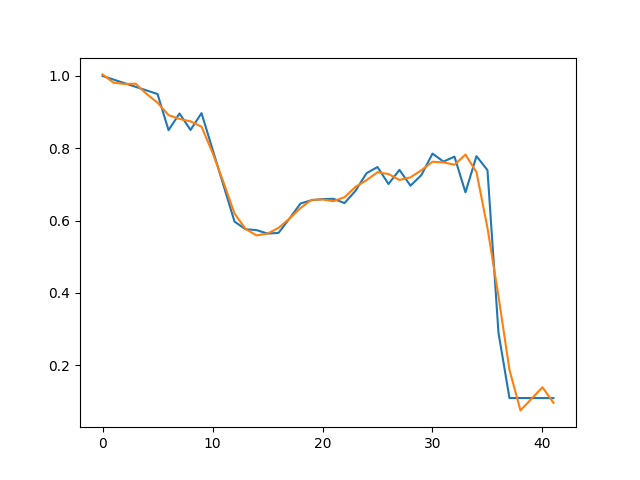

42 41


<IPython.core.display.Javascript object>


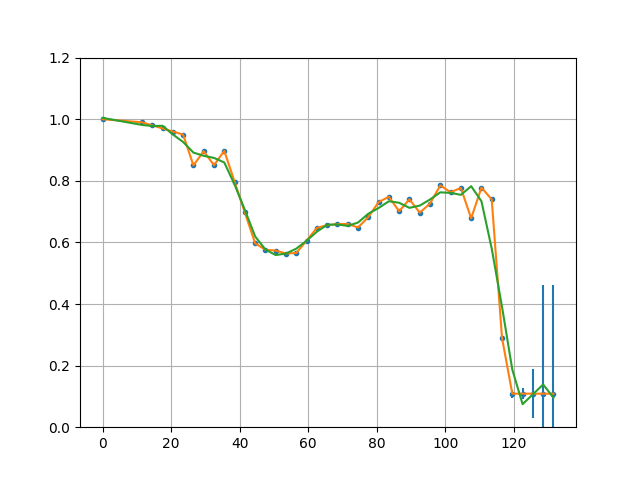

<IPython.core.display.Javascript object>


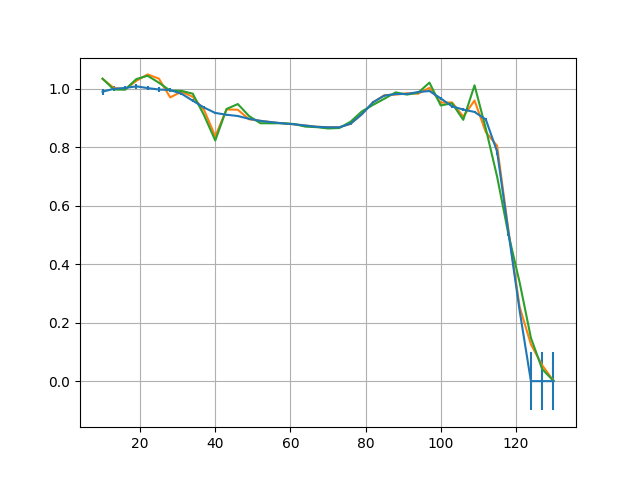

In [24]:
plt.figure()
w1 = trafo(m.np_values())
plt.plot(w1)
#w1[0] = 0.9
#w1/=np.amax(w1)
yhat = savgol_filter(w1, 7, 3) # window size 51, polynomial order 3
w2 = inverse_trafo(yhat)
#w2 /= np.amax(w2)
print(yhat.size, w2.size)

plt.plot(yhat)

plt.figure()

plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()), yerr = np.append(0,m.np_errors()), fmt =  '.')
plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()))
plt.errorbar(np.append(0,x+step/2),y=yhat)

plt.ylim(0,1.2)
plt.grid()

plt.figure()

plt.errorbar(x,y, yerr = y_err)

mdl = model(m.np_values())
plt.plot(x[mdl>0],mdl[mdl>0])

mdl = model(w2)
plt.plot(x[mdl>0],mdl[mdl>0])
#plt.plot(np.arange(0,40,0.01),model2(np.arange(0,40,0.01),m.np_values()))

#plt.ylim(0,1.2)
plt.grid()


np.savetxt("DOMfit.txt", (m.np_values(), m.np_errors()))
with open("DOM_weights.txt", "w") as f:
    for r, y in zip(np.append(0,x+step/2), yhat):
        f.write(f"{r}\t{y}\n")

# D-EGG


dict_keys(['x', 'y', 'rDE', 'gain', 'TT', 'TTS', 'size', 'R', 'ix', 'iy', 'occupancy', 'TTS_c'])


<IPython.core.display.Javascript object>


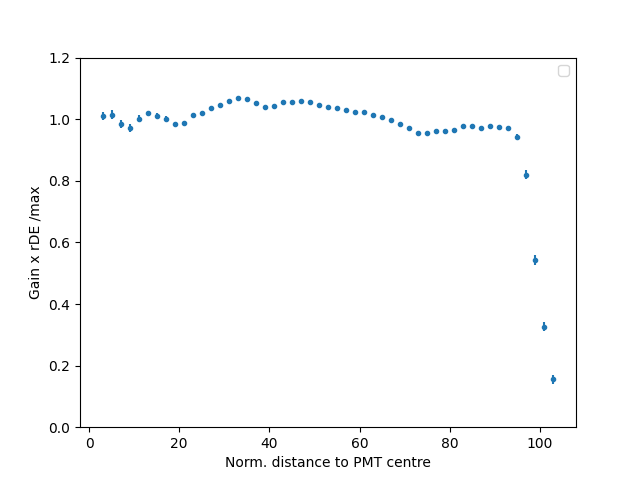

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


76.42390516880172 105


In [25]:
path = "/HDD/backuped/Promotion_data/Thesis/"
DEGG = load_dict(path+f"data/data_in_elements/SQ0797-2dyndown-2_SPE_dict_scan_D-Egg")
DEGG_t = load_dict(path+f"data/data_in_elements/SQ0797-2dyndown-2_TT_dict_scan_D-Egg")
DEGG["size"] = DEGG_t["size"]
print(DOM.keys())

rmax = 105

rnorm = 202/2
Rcentre = 40

x0 = -3
y0 = -1
DOM["R"] = np.sqrt((DOM["x"]-x0)**2+(DOM["y"]-y0)**2)


step = 2
#Rhist = np.arange(step*3,1,step*2)
Rhist = np.arange(3,rmax,step)

key = "rDE"

lim = 0.2
plt.figure()

dictionary = DEGG
print(0.75*np.amax(dictionary["R"]), rmax)
meanSize = np.mean(dictionary["size"][dictionary["R"]<lim*np.amax(dictionary["R"])])

bl = np.logical_and(dictionary["size"]>meanSize*0.05, dictionary["R"]<rmax)
norm = np.mean(dictionary[key][dictionary["R"]<lim*np.amax(dictionary["R"])])*np.mean(dictionary["rDE"][dictionary["R"]<lim*np.amax(dictionary["R"])])

#plt.plot(dictionary["R"][bl]/rmax, dictionary[key][bl]/norm, '.', alpha = 0.5, markersize = 1)
mn = []
std = []
for R in Rhist:
    bl2 = np.logical_and(dictionary["R"][bl] > R-step, dictionary["R"][bl]<R+step)
    if (dictionary[key][bl])[bl2].size > 1:
        mn.append(np.mean((dictionary[key][bl])[bl2]))
        std.append(np.std((dictionary[key][bl])[bl2])/np.sqrt((dictionary[key][bl])[bl2].size-1))
    else:
        mn.append(0)
        std.append(0)
        
mn = np.array(mn)
norm = np.mean(mn[Rhist<25])
y = mn/norm
y_err = np.array(std)/norm
for i in range(y_err.size):
    if y_err[i] == 0:
        y_err[i] = 0.1
x=Rhist.copy()
plt.errorbar(Rhist, y, yerr=y_err, fmt= '.')
    
plt.legend()
plt.ylabel("Gain x rDE /max")
plt.xlabel("Norm. distance to PMT centre")
plt.ylim(0,1.2)



# Pre-calculate bl2 masks to avoid repeated computation
bl2_masks = np.empty((Rhist.size-1, Rs.size), dtype=bool)
for i in range(Rhist.size-1):
    bl2_masks[i] = np.logical_and(Rs < Rhist[i+1], Rs >= Rhist[i])


In [26]:
%%capture
step = .5
Rbins = np.arange(0,104+step,step)
Rbins_x = 0.5*(Rbins[:-1]+Rbins[1:])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def readfn(fname):
    xd, yd = np.loadtxt(fname, unpack=1, usecols=(0,1), skiprows=1)
    xd *= 1000
    yd *= 1000
    R = np.sqrt(xd**2+yd**2)

    h, bins = np.histogram(R, bins = Rbins)   
    return h

xx = np.arange(-103, 104, 1)
matrix = np.zeros((xx.size,xx.size))#+np.nan

dicts = {}
Rs = np.arange(0, 103, 1)

for r in Rs:
    dicts[r] = {} 
    dicts[r]["hist"] = np.zeros(Rbins.size-1)
    dicts[r]["counts"] = 0

# for i,x in enumerate(xx):
#     for j,y in enumerate(xx):
#         Rfile = np.sqrt(x**2+y**2)
#         try:
#             #fname = f"SimulationScan/output{thickness}/{x}_{y}.txt"
#             fname = f"DEGGScan/{x}_{y}.txt"
#             h = readfn(fname)
#             dicts[find_nearest(Rs,Rfile)]["hist"] += h
#             dicts[find_nearest(Rs,Rfile)]["counts"] +=1
#         except Exception as err:
#             print(err)
#             pass
# with open(f'saved_dictionary_detailed_DEGG.pkl', 'wb') as f:
#     pickle.dump(dicts, f)

<IPython.core.display.Javascript object>


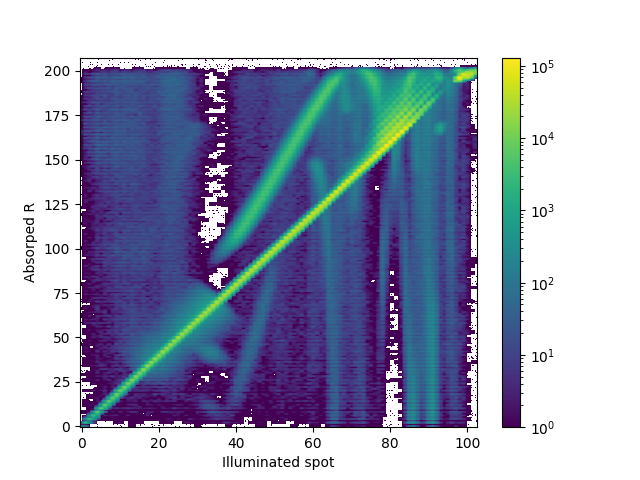

Text(0, 0.5, 'Absorped R')

In [27]:
dicts = load_dict(f"saved_dictionary_detailed_DEGG.pkl")
matrix = []
mean = []
maxp = []
for r in Rs:
    matrix.append(dicts[r]["hist"])#/np.sum(dicts[r]))
    try:
        mean.append(np.average(Rbins_x, weights=dicts[r]["hist"]))
        maxp.append(np.mean(Rbins_x[dicts[r]["hist"]==np.amax(dicts[r]["hist"])]))
    except:
        mean.append(0)
        maxp.append(0)
maxp = np.array(maxp)
plt.figure()
im = plt.imshow(np.array(matrix).T, aspect="auto", origin="lower", norm = LogNorm())
plt.colorbar(im)
plt.xlabel("Illuminated spot")
plt.ylabel("Absorped R")


In [181]:
# oldx, oldy = np.loadtxt("weightsVsR_vFit_220nm.txt", unpack=1)
diffs = [0,]
for i in range(Rhist.size-1):
    diffs.append(0.0001)
    
f = interp1d(Rhist, diffs)
in_values = f(Rhist)
print(in_values)
initial = {}
limits = {}
fix = {}
error = {}
names = list()
for i,val in enumerate(in_values):
    names.append("w_"+str(i))
    initial[names[-1]] = val
    if i<5:
        limits["limit_"+names[-1]] = (0.0, 0.001)
#     elif i<20:
#         limits["limit_"+names[-1]] = (0.0, 0.05)
#     elif i>45:
#         limits["limit_"+names[-1]] = (0.0, 0.5)
    else:
        limits["limit_"+names[-1]] = (-0.1, 0.1)
        
    error["error_"+names[-1]] = 0.5
    fix["fix_"+names[-1]] = False
 
#print(model(np.ones(Rhist.size)))

minuit_args = {**initial, **limits, **error, **fix, **dict(errordef= 1)}


m = Minuit(chi, name=names, **minuit_args)
m.strategy = 0
m.migrad(ncall = 50000)



[0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001]


------------------------------------------------------------------
| FCN = 8.964e+04               |   Ncalls=19171 (20840 total)   |
| EDM = 0.0001 (Goal: 0.0002)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | w_0  |  1.00e-3  |  0.04e-3  |            |            |    0    |  0.001  |       |
| 1 | w_1  |  1.00e-3  |  0.05e-3  |            |            |    0    |  0.001  |       |
| 2 | w_2  |  1.00e-3  |  0.07e-3  |            |            |    0    |  0.001  |       |
| 3 | w_3  |  1.00e-3  |  0.09e-3  |            |            |    0    |  0.001  |       |
| 4 | w_4  |  1.00e-3  |  0.14e-3  |            |            |    0    |  0.001  |       |
| 5 | w_5  | 100.0e-3  |  0.4e-3   |            |            |  -0.1   |   0.1   |       |
| 6 | w_6  | 100.0e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 7 | w_7  |  -0.003   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 8 | w_8  |  -0.004   |   0.011   |            |            |  -0.1   |   0.1   |       |
| 9 | w_9  |  -0.018   |   0.009   |            |            |  -0.1   |   0.1   |       |
| 10| w_10 | -99.9e-3  |  0.8e-3   |            |            |  -0.1   |   0.1   |       |
| 11| w_11 |   0.006   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 12| w_12 |   0.002   |   0.009   |            |            |  -0.1   |   0.1   |       |
| 13| w_13 |  -0.023   |   0.010   |            |            |  -0.1   |   0.1   |       |
| 14| w_14 |   0.030   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 15| w_15 |  -0.034   |   0.007   |            |            |  -0.1   |   0.1   |       |
| 16| w_16 | -99.9e-3  |  0.8e-3   |            |            |  -0.1   |   0.1   |       |
| 17| w_17 |   0.056   |   0.005   |            |            |  -0.1   |   0.1   |       |
| 18| w_18 | 100.00e-3 |  0.25e-3  |            |            |  -0.1   |   0.1   |       |
| 19| w_19 | 100.00e-3 |  0.28e-3  |            |            |  -0.1   |   0.1   |       |
| 20| w_20 |   0.016   |   0.007   |            |            |  -0.1   |   0.1   |       |
| 21| w_21 |  -0.057   |   0.011   |            |            |  -0.1   |   0.1   |       |
| 22| w_22 |   0.052   |   0.012   |            |            |  -0.1   |   0.1   |       |
| 23| w_23 |   0.001   |   0.011   |            |            |  -0.1   |   0.1   |       |
| 24| w_24 |  -0.071   |   0.009   |            |            |  -0.1   |   0.1   |       |
| 25| w_25 |  -0.053   |   0.009   |            |            |  -0.1   |   0.1   |       |
| 26| w_26 |  -0.033   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 27| w_27 |   0.059   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 28| w_28 |   0.077   |   0.010   |            |            |  -0.1   |   0.1   |       |
| 29| w_29 |   0.090   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 30| w_30 |   0.028   |   0.008   |            |            |  -0.1   |   0.1   |       |
| 31| w_31 |  -0.084   |   0.006   |            |            |  -0.1   |   0.1   |       |
| 32| w_32 

<IPython.core.display.Javascript object>


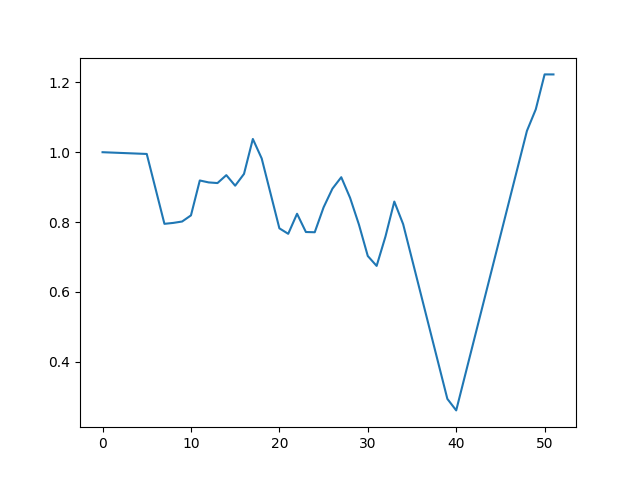

<IPython.core.display.Javascript object>


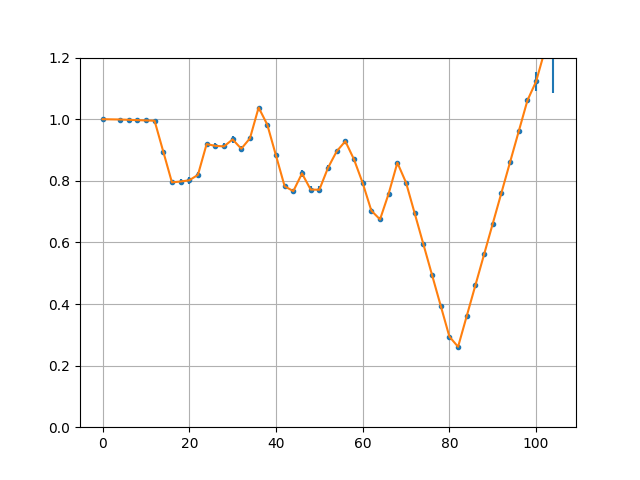

<IPython.core.display.Javascript object>


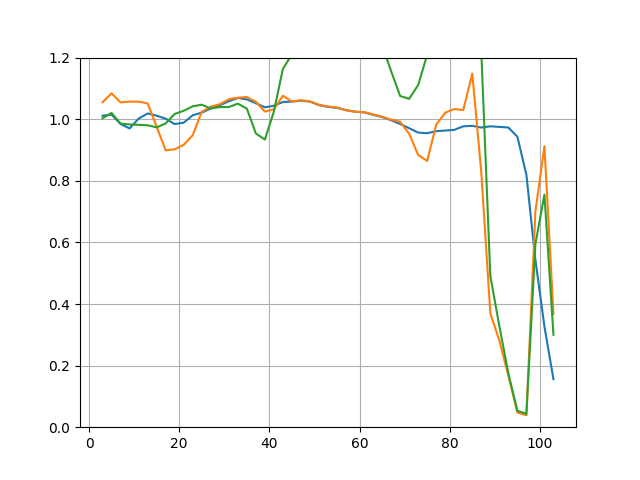

In [184]:
plt.figure()
plt.plot(trafo(m.np_values()))

plt.figure()

plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()), yerr = np.append(0,m.np_errors()), fmt =  '.')
plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()))


plt.ylim(0,1.2)
plt.grid()

plt.figure()

plt.plot(x,y)

mdl = model(m.np_values())
plt.plot(x[mdl>0],mdl[mdl>0])

mdl = model(np.zeros(m.np_values().size))
plt.plot(x[mdl>0],mdl[mdl>0])
#plt.plot(np.arange(0,40,0.01),model2(np.arange(0,40,0.01),m.np_values()))

plt.ylim(0,1.2)
plt.grid()

In [173]:
weights = np.zeros(m.np_values().size)
weights = trafo(weights) #fit parameters is difference to last weight, but we need the weights

line = []
f = interp1d(np.append(0,x+step/2.), weights, kind = "slinear") 
weights_detailed = f(Rbins_x)

for r in Rs:
    line.append(np.nansum(dicts[r]["hist"]*weights_detailed/dicts[r]["counts"])*100/N)#/np.sum(dicts[r]))

line = np.array(line)

mn = []
bl2 = Rs<Rhist[0]
mn.append(np.nanmean(line[line>0][bl2[line>0]]))
print(line)
for i in range(Rhist.size-1):

    bl2 = np.logical_and(Rs<Rhist[i+1], Rs>=Rhist[i] )
    mn.append(np.nanmean(line[bl2]))

line = np.array(mn)
norm = np.nanmean(line[line>0][Rhist[line>0]<25])

[35.3        36.5875     36.05833333 36.80625    36.390625   35.38928571
 35.33       35.5625     34.95416667 35.37058824 35.06785714 34.75138889
 35.58235294 35.00113636 34.83863636 35.34285714 35.41696429 36.35089286
 36.62142857 36.74137931 36.97053571 37.26597222 37.48571429 37.46736111
 37.65972222 37.10833333 37.12378049 37.304375   37.27554348 37.2627907
 37.3025     37.6328125  37.74148936 37.36730769 36.84508929 34.99241071
 33.44517544 33.225      33.77298387 35.23813559 38.30037879 40.98629032
 42.50530303 43.18007246 43.64962121 43.778125   43.68478261 43.6
 43.65559211 43.69198718 43.58892405 43.770625   43.70145349 43.82594937
 43.72470238 43.66193182 43.45470588 43.60478723 43.51875    43.83877551
 44.15657895 44.6701087  45.04375    45.01675824 43.96681818 42.20075
 40.72688679 38.59571429 38.55360577 38.07901786 38.40911215 39.69537037
 40.01291667 41.53693694 45.22838983 51.55701754 60.04303279 73.1536
 87.28728814 96.2016129  98.5453252  93.71511194 90.69667969 89.19

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


# LOM


dict_keys(['Q0', 's0', 'Q1', 's1', 'occupancy', 'height', 'omega', 'alpha', 'gof', 'rDE', 'R', 'x', 'y', 'idx', 'ix', 'iy', 'gain_err', 'gain', 'SPE_resolution', 'PE', 'size'])


<IPython.core.display.Javascript object>


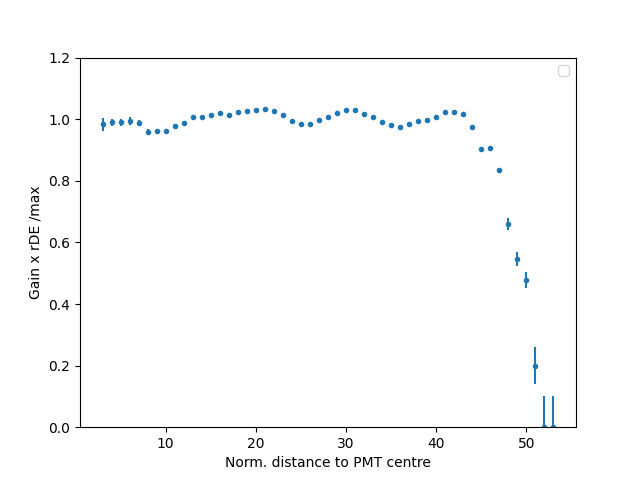

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


39.74518838803007 54


In [33]:
path = "/HDD/backuped/Promotion_data/Thesis/"
SN = "9741-2"
LOM = load_dict(path+f"data/data_in_elements/{SN}_SPE_dict_scan_LOM")
LOM_t = load_dict(path+f"data/data_in_elements/{SN}_TT_dict_scan_LOM")
LOM["size"] = LOM_t["size"]
print(LOM.keys())

rmax = 54

rnorm = 101.6/2

Rcentre = 25
x0 = -3
y0 = -1
DOM["R"] = np.sqrt((DOM["x"]-x0)**2+(DOM["y"]-y0)**2)


step = 0.5
#Rhist = np.arange(step*3,1,step*2)
Rhist = np.arange(3,rmax,step*2)

key = "rDE"

lim = 0.2
plt.figure()

dictionary = LOM
print(0.75*np.amax(dictionary["R"]), rmax)
meanSize = np.mean(dictionary["size"][dictionary["R"]<lim*np.amax(dictionary["R"])])

bl = np.logical_and(dictionary["size"]>meanSize*0.05, dictionary["R"]<rmax)
norm = np.mean(dictionary[key][dictionary["R"]<lim*np.amax(dictionary["R"])])*np.mean(dictionary["rDE"][dictionary["R"]<lim*np.amax(dictionary["R"])])

#plt.plot(dictionary["R"][bl]/rmax, dictionary[key][bl]/norm, '.', alpha = 0.5, markersize = 1)
mn = []
std = []
for R in Rhist:
    bl2 = np.logical_and(dictionary["R"][bl] > R-step, dictionary["R"][bl]<R+step)
    if (dictionary[key][bl])[bl2].size > 1:
        mn.append(np.mean((dictionary[key][bl])[bl2]))
        std.append(np.std((dictionary[key][bl])[bl2])/np.sqrt((dictionary[key][bl])[bl2].size-1))
    else:
        mn.append(0)
        std.append(0)
        
mn = np.array(mn)
norm = np.mean(mn[Rhist<25])
y = mn/norm
y_err = np.array(std)/norm
for i in range(y_err.size):
    if y_err[i] == 0:
        y_err[i] = 0.1
x=Rhist.copy()
plt.errorbar(Rhist, y, yerr=y_err, fmt= '.')
    
plt.legend()
plt.ylabel("Gain x rDE /max")
plt.xlabel("Norm. distance to PMT centre")
plt.ylim(0,1.2)




# Pre-calculate bl2 masks to avoid repeated computation
bl2_masks = np.empty((Rhist.size-1, Rs.size), dtype=bool)
for i in range(Rhist.size-1):
    bl2_masks[i] = np.logical_and(Rs < Rhist[i+1], Rs >= Rhist[i])

In [29]:
%%capture
step = .25
Rbins = np.arange(0,53+step,step)
Rbins_x = 0.5*(Rbins[:-1]+Rbins[1:])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def readfn(fname):
    xd, yd = np.loadtxt(fname, unpack=1, usecols=(0,1), skiprows=1)
    xd *= 1000
    yd *= 1000
    R = np.sqrt(xd**2+yd**2)

    h, bins = np.histogram(R, bins = Rbins)   
    return h

xx = np.arange(-53, 54, 1)
matrix = np.zeros((xx.size,xx.size))#+np.nan

dicts = {}
Rs = np.arange(0, 53, 0.5)

# for r in Rs:
#     dicts[r] = {} 
#     dicts[r]["hist"] = np.zeros(Rbins.size-1)
#     dicts[r]["counts"] = 0

# for i,x in enumerate(xx):
#     for j,y in enumerate(xx):
#         Rfile = np.sqrt(x**2+y**2)
#         try:
#             #fname = f"SimulationScan/output{thickness}/{x}_{y}.txt"
#             fname = f"LOMScan/{x}_{y}.txt"
#             h = readfn(fname)
#             dicts[find_nearest(Rs,Rfile)]["hist"] += h
#             dicts[find_nearest(Rs,Rfile)]["counts"] +=1
#         except Exception as err:
#             print(err)
#             pass
# with open(f'saved_dictionary_detailed_LOM.pkl', 'wb') as f:
#     pickle.dump(dicts, f)

<IPython.core.display.Javascript object>


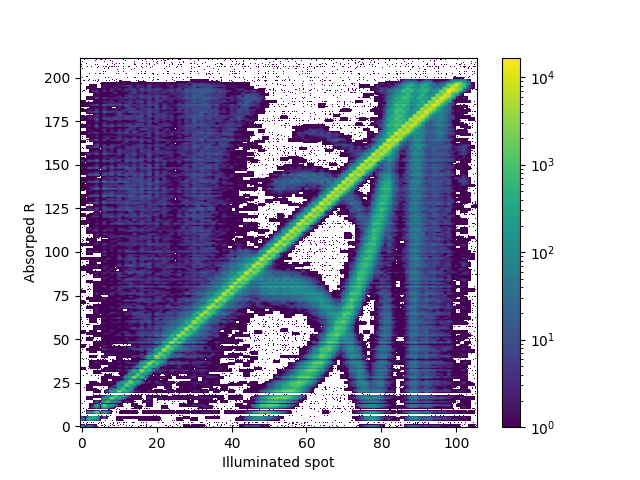

In [31]:
dicts = load_dict(f"saved_dictionary_detailed_LOM.pkl")
matrix = []
mean = []
maxp = []
for r in Rs:
    matrix.append(dicts[r]["hist"])#/np.sum(dicts[r]))
    try:
        mean.append(np.average(Rbins_x, weights=dicts[r]["hist"]))
        maxp.append(np.mean(Rbins_x[dicts[r]["hist"]==np.amax(dicts[r]["hist"])]))
    except:
        mean.append(0)
        maxp.append(0)
maxp = np.array(maxp)
plt.figure()
im = plt.imshow(np.array(matrix).T, aspect="auto", origin="lower", norm = LogNorm())
plt.colorbar(im)
plt.xlabel("Illuminated spot")
plt.ylabel("Absorped R")
N=1000

In [34]:
# oldx, oldy = np.loadtxt("weightsVsR_vFit_220nm.txt", unpack=1)
diffs = [0,]
for i in range(Rhist.size-1):
    diffs.append(0.0001)
    
f = interp1d(Rhist, diffs)
in_values = f(Rhist)
print(in_values)
initial = {}
limits = {}
fix = {}
error = {}
names = list()
for i,val in enumerate(in_values):
    names.append("w_"+str(i))
    initial[names[-1]] = val
    if i<5:
        limits["limit_"+names[-1]] = (0.0, 0.001)
    elif i<20:
        limits["limit_"+names[-1]] = (0.0, 0.05)
    elif i>45:
        limits["limit_"+names[-1]] = (0.0, 0.5)
    else:
        limits["limit_"+names[-1]] = (-0.1, 0.1)
        
    error["error_"+names[-1]] = 0.5
    fix["fix_"+names[-1]] = False
 
#print(model(np.ones(Rhist.size)))

minuit_args = {**initial, **limits, **error, **fix, **dict(errordef= 1)}


m = Minuit(chi, name=names, **minuit_args)
m.strategy = 0
m.tol = 1e-12
m.migrad(ncall = 500000)



[0.     0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001]


/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


------------------------------------------------------------------
| FCN = 213.8                   |    Ncalls=650 (60103 total)    |
| EDM = 8.62e-11 (Goal: 2e-15)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | w_0  |   1e-3    |   1e-3    |            |            |    0    |  0.001  |       |
| 1 | w_1  |   0e-3    |   1e-3    |            |            |    0    |  0.001  |       |
| 2 | w_2  |     0     |  0.8e-3   |            |            |    0    |  0.001  |       |
| 3 | w_3  |  1.0e-3   |  0.5e-3   |            |            |    0    |  0.001  |       |
| 4 | w_4  |   1e-3    |   1e-3    |            |            |    0    |  0.001  |       |
| 5 | w_5  |  0.0144   |  0.0016   |            |            |    0    |  0.05   |       |
| 6 | w_6  |  0.0074   |  0.0015   |            |            |    0    |  0.05   |       |
| 7 | w_7  |  0.0010   |  0.0013   |            |            |    0    |  0.05   |       |
| 8 | w_8  |  0.0069   |  0.0012   |            |            |    0    |  0.05   |       |
| 9 | w_9  |   0.000   |   0.008   |            |            |    0    |  0.05   |       |
| 10| w_10 |  0.0061   |  0.0011   |            |            |    0    |  0.05   |       |
| 11| w_11 |  0.0000   |  0.0034   |            |            |    0    |  0.05   |       |
| 12| w_12 |     0     |  0.8e-3   |            |            |    0    |  0.05   |       |
| 13| w_13 |     0     |  0.5e-3   |            |            |    0    |  0.05   |       |
| 14| w_14 |     0     |  0.4e-3   |            |            |    0    |  0.05   |       |
| 15| w_15 |     0     |  0.7e-3   |            |            |    0    |  0.05   |       |
| 16| w_16 |  2.6e-3   |  0.9e-3   |            |            |    0    |  0.05   |       |
| 17| w_17 | 2.6196e-5 |    nan    |            |            |    0    |  0.05   |       |
| 18| w_18 |  0.0000   |  0.0018   |            |            |    0    |  0.05   |       |
| 19| w_19 |     0     |  0.9e-3   |            |            |    0    |  0.05   |       |
| 20| w_20 |   0.100   |   0.007   |            |            |  -0.1   |   0.1   |       |
| 21| w_21 | 100.00e-3 |  0.35e-3  |            |            |  -0.1   |   0.1   |       |
| 22| w_22 | 100.0e-3  |  0.5e-3   |            |            |  -0.1   |   0.1   |       |
| 23| w_23 |  37.6e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 24| w_24 | -66.4e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 25| w_25 |  19.7e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 26| w_26 | -20.0e-3  |  0.9e-3   |            |            |  -0.1   |   0.1   |       |
| 27| w_27 | -12.4e-3  |  1.0e-3   |            |            |  -0.1   |   0.1   |       |
| 28| w_28 |  0.0411   |  0.0010   |            |            |  -0.1   |   0.1   |       |
| 29| w_29 |  -0.0121  |  0.0010   |            |            |  -0.1   |   0.1   |       |
| 30| w_30 |  0.0306   |  0.0011   |            |            |  -0.1   |   0.1   |       |
| 31| w_31 |  -0.0026  |  0.0011   |            |            |  -0.1   |   0.1   |       |
| 32| w_32 

<IPython.core.display.Javascript object>


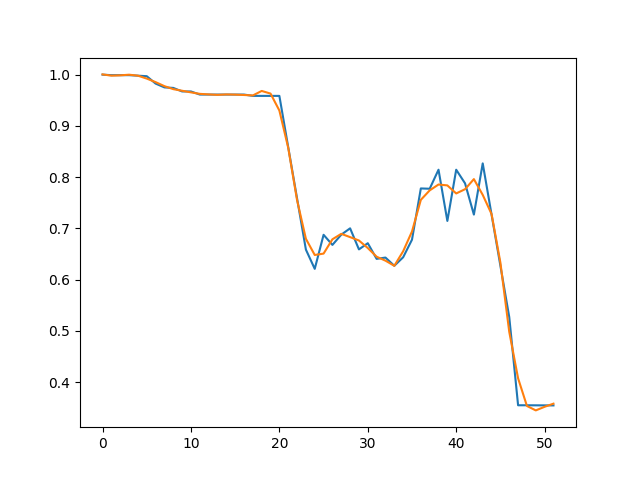

52 51


<IPython.core.display.Javascript object>


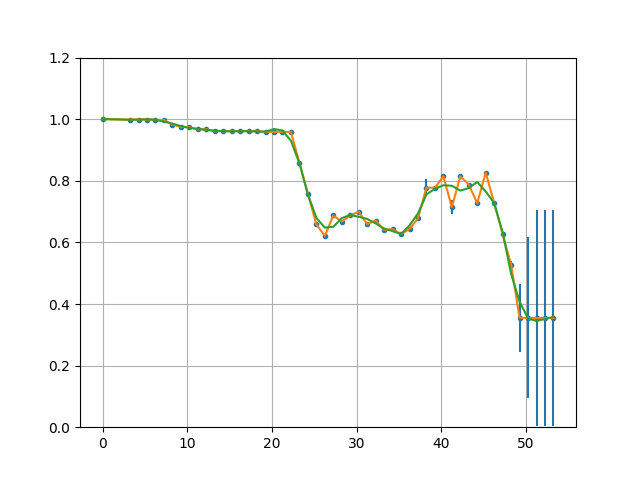

<IPython.core.display.Javascript object>


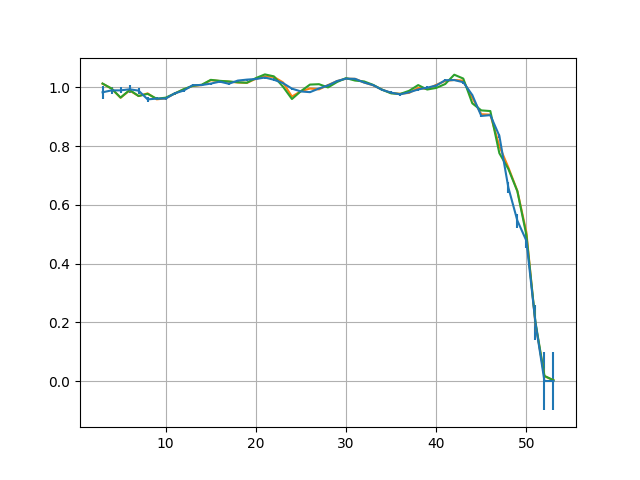

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


In [36]:
plt.figure()
w1 = trafo(m.np_values())
plt.plot(w1)
#w1[0] = 0.9
#w1/=np.amax(w1)
yhat = savgol_filter(w1, 7, 3) # window size 51, polynomial order 3
w2 = inverse_trafo(yhat)
#w2 /= np.amax(w2)
print(yhat.size, w2.size)

plt.plot(yhat)

plt.figure()

plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()), yerr = np.append(0,m.np_errors()), fmt =  '.')
plt.errorbar(np.append(0,x+step/2),y=trafo(m.np_values()))
plt.errorbar(np.append(0,x+step/2),y=yhat)

plt.ylim(0,1.2)
plt.grid()

plt.figure()

plt.errorbar(x,y, yerr = y_err)

mdl = model(m.np_values())
plt.plot(x[mdl>0],mdl[mdl>0])

mdl = model(w2)
plt.plot(x[mdl>0],mdl[mdl>0])
#plt.plot(np.arange(0,40,0.01),model2(np.arange(0,40,0.01),m.np_values()))

#plt.ylim(0,1.2)
plt.grid()


np.savetxt("LOMfit.txt", (m.np_values(), m.np_errors()))
with open("LOM_weights.txt", "w") as f:
    for r, y in zip(np.append(0,x+step/2), yhat):
        f.write(f"{r}\t{y}\n")

In [117]:
chi(*diffs)

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


30265.60748058794